# Web Scraping, EDA & Simple Recommendation System on IMDb top 1000 dataset

## Libraries & prep

In this section, I am exporting the libraries I will be using in my code below. I am also using an API for obtaining a proxy which allows me scrape the data off websites seemlessly and not get banned. 

In [1]:
import requests
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from time import sleep
from random import randint
from urllib.parse import urlencode

In [6]:
API_KEY = 'bf2c61b3-31e4-4c0c-926f-329c2ed958d4'

def get_scrapeops_url(url):
    payload = {'api_key': API_KEY, 'url': url}
    proxy_url = 'https://proxy.scrapeops.io/v1/?' + urlencode(payload)
    return proxy_url

## Coding implementation, Web Scraping

In this section, I have implemented a web scraper that parses through multiple website pages and scrapes the need information off each one of them. The information is scraped off each individual page in function page_scraper(movies), while scrape_every_page(link_start, link_end) function iterates over multiple needed web pages, calling page_scraper() on each one of them. it should be noted that the below functions are written to scrape IMDb top-x movies, they are gathering the following information: titles, years, run_times, genres, ratings, votes, directors, stars, descriptions. 

In [48]:
def scrape_every_page(link_start, link_end):
    """
    Scrapes movie descriptions from multiple pages on a website.

    Args:
        link_start (str): The starting part of the URL.
        link_end (str): The ending part of the URL.

    Returns:
        list: A list of movie descriptions scraped from each page, list of data frames.

    """
    s = requests.Session() # not to get banned
    movie_desc = []
    
    # iterates over the number of pages we want to scrape
    for _ in range(1, 1001, 100):
        next_page = s.get(get_scrapeops_url(link_start+str(_)+link_end))
        next_page_text = BeautifulSoup(next_page.text, "lxml")
        # HTML code for all the "boxes" we want to iterate over within a page
        movies_descriptions = next_page_text.find_all('div', 'lister-item mode-advanced')
        movie_desc.append(page_scraper(movies_descriptions))
    return movie_desc

In [50]:
def page_scraper(movies):
    """
    Extracts relevant information from a list of movie elements within a single page.

    Args:
        movies (list): A list of movie elements we want to gather info from within a single page.

    Returns:
        pandas.DataFrame: A DataFrame containing the extracted information from every page.

    """
    titles, years, run_times, genres = [], [], [], []
    ratings, votes, directors, stars, descriptions =  [], [], [], [], []
    
    # extracting the needed info from each movie on the page
    for m in movies:
        
        titles.append(m.h3.a.text)
        years.append(m.h3.find("span", class_ = "lister-item-year text-muted unbold").text) 
        run_times.append(m.p.find("span", class_ = "runtime").text)
        genres.append(m.p.find("span", class_ = "genre").text)
        rate = re.findall("\d+\.\d+", m.find("div", class_ = "inline-block ratings-imdb-rating").text)
        ratings.append(rate)
        # only selecting the second element of tag "p" (=descriptions)
        descriptions.append(m.find_all("p", limit = 2)[1].text)
        # number of votes
        cat = m.find("p", class_ = "sort-num_votes-visible")
        n = cat.find_all("span")
        votes.append(n[1].text)

        people = m.find("p", class_ = "").text
        people = re.sub('[^a-zA-Z0-9 ,]|[\s]', '', people) # getting rid of non-letters except commas
        people = re.sub(",", ' ', people) # substituting commas as white spaces
        separated = re.split('(?=Stars)', people) # separating stars and directors
        p_d = [_.replace("Director", '') for _ in separated]
        people_new = [_.replace("Stars", '') for _ in p_d]
        directors.append(people_new[0])
        stars.append(people_new[1])

    ratings = [val for sublist in ratings for val in sublist] # getting rid of double lists
    
    page_top = {"Title": titles,
              "Year": years, 
              "Run Time(min)": run_times, 
              "Genre": genres, 
              "Rating": ratings,
              "Votes": votes,
              "Directors": directors,
              "Stars": stars, 
                "Descriptions": descriptions}
    
    page_top_df = pd.DataFrame(page_top)
    return page_top_df

In the below cell I am calling the function to scrape the wanted information off each web page on IMDb top-1000 website.

In [52]:
link_s = "https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start="
link_e = "&ref_=adv_nxt"
top_1000_data = scrape_every_page(link_s, link_e)

After this step I have all the information I wanted to know about the top-1000 movies stored in dataframes.

### Unused working code

In [5]:
headers = {"Accept-Language": "en-US, en;q=0.5"}

The code below can be useful to test the above function or the review_scraper function below on individual web pages before scaling to scraping every webpage.

In [7]:
# for a single page
s = requests.Session()
url = 'https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&ref_=adv_prv'
info = s.get(get_scrapeops_url(url))
info_text = BeautifulSoup(info.text, "lxml")
movies_ = info_text.find_all('div', 'lister-item mode-advanced')

Initially I was planning on scraping every review on top of the information I already scraped above in order to create a more robust recommendation system later. However, I changed my mind because I realized it would be very computationally expensive to gather each user's reviews on multiple movies in order to comprise a full user-item matrix. <br><br> However, the code below, review_scraper(movies), scrapes every review left on every single movies within a web page. The function could be run on every page, similarly to how it is done above, in order to get every review written for every movie within the top-1000.

In [311]:
# not run on every page yet
def review_scraper(movies):
    s = requests.Session()
    reviews_all = [] # stores list of lists, reviews of all movies on the web page
    
    for m in movies:
        reviews = [] # stores one movie reviews
        # assembling the link
        start = "https://www.imdb.com"
        r_link = m.h3.a.get("href")
        end = "reviews?ref_=tt_urv"
        
        _link = s.get(get_scrapeops_url(start+ str(r_link) + end))
        soup1 = BeautifulSoup(_link.text, "lxml")
        print("working")
        sleep(randint(2,5))
        rev = soup1.find_all('div', class_ ='lister-item-content')
        
        # loops through every review on the page
        for r in rev:
            one = r.find("div", class_ = "content").text
            reviews.append(one)
        reviews_all.append(reviews)
    
    return reviews_all

## Data cleaning & EDA

In [53]:
# joing all the data from all the pages scraped into one dataframe
final_df = pd.concat([top_1000_data[0],top_1000_data[1], top_1000_data[2],
                     top_1000_data[3], top_1000_data[4], top_1000_data[5], top_1000_data[6], 
                     top_1000_data[7], top_1000_data[8], top_1000_data[9]], ignore_index= True)

In [54]:
final_df.head(10)

,Title,Year,Run Time(min),Genre,Rating,Votes,Directors,Stars,Descriptions
0,The Shawshank Redemption,(1994),142 min,\nDrama,9.3,"2,749,930",FrankDarabont,TimRobbins MorganFreeman BobGunton WilliamSadler,"\nOver the course of several years, two convic..."
1,The Godfather,(1972),175 min,"\nCrime, Drama",9.2,"1,912,737",FrancisFordCoppola,MarlonBrando AlPacino JamesCaan DianeKeaton,"\nDon Vito Corleone, head of a mafia family, d..."
2,Spider-Man: Across the Spider-Verse,(2023),140 min,"\nAnimation, Action, Adventure",9.0,"95,163",sJoaquimDosSantos KempPowers JustinKThompson,ShameikMoore HaileeSteinfeld BrianTyreeHenry L...,\nMiles Morales catapults across the Multivers...
3,The Dark Knight,(2008),152 min,"\nAction, Crime, Drama",9.0,"2,722,695",ChristopherNolan,ChristianBale HeathLedger AaronEckhart Michael...,\nWhen the menace known as the Joker wreaks ha...
4,Schindler's List,(1993),195 min,"\nBiography, Drama, History",9.0,"1,386,866",StevenSpielberg,LiamNeeson RalphFiennes BenKingsley CarolineGo...,\nIn German-occupied Poland during World War I...
5,The Godfather Part II,(1974),202 min,"\nCrime, Drama",9.0,"1,302,749",FrancisFordCoppola,AlPacino RobertDeNiro RobertDuvall DianeKeaton,\nThe early life and career of Vito Corleone i...
6,The Lord of the Rings: The Return of the King,(2003),201 min,"\nAction, Adventure, Drama",9.0,"1,889,533",PeterJackson,ElijahWood ViggoMortensen IanMcKellen OrlandoB...,\nGandalf and Aragorn lead the World of Men ag...
7,12 Angry Men,(1957),96 min,"\nCrime, Drama",9.0,"814,349",SidneyLumet,HenryFonda LeeJCobb MartinBalsam JohnFiedler,\nThe jury in a New York City murder trial is ...
8,Pulp Fiction,(1994),154 min,"\nCrime, Drama",8.9,"2,112,645",QuentinTarantino,JohnTravolta UmaThurman SamuelLJackson BruceWi...,"\nThe lives of two mob hitmen, a boxer, a gang..."
9,Inception,(2010),148 min,"\nAction, Adventure, Sci-Fi",8.8,"2,416,660",ChristopherNolan,LeonardoDiCaprio JosephGordonLevitt ElliotPage...,\nA thief who steals corporate secrets through...


### Cleaning the data

In [55]:
# replacing all the other characters except for numbers in the Year column
# turning Years into integers
final_df['Year'] = [re.sub('[\W_]+', '', t) for t in final_df['Year']]
final_df['Year'] = [t.replace("II", "") for t in final_df['Year']]
final_df['Year'] = [t.replace("I", "") for t in final_df['Year']]
final_df['Year'] = [int(t) for t in final_df['Year']]

In [56]:
# getting rid of "min" next to duration and turning it to integer
final_df['Run Time(min)'] = [t.replace(" min", '') for t in final_df['Run Time(min)']]
final_df['Run Time(min)'] = [int(t) for t in final_df['Run Time(min)']]

In [57]:
# replacing remaining "\n" symbols from Genres and converting to string
final_df['Genre'] = [t.replace("\n", '') for t in final_df['Genre']]
final_df['Genre'] = [str(t) for t in final_df['Genre']]
final_df["Genre"] = [g.replace("            ", '') for g in final_df["Genre"]]

In [565]:
final_df["Genre"] = [g.replace(',', ' ') for g in final_df["Genre"]]

In [58]:
final_df["Descriptions"] = [d.replace("\n", '') for d in final_df["Descriptions"]]

In [60]:
final_df['Rating'] = [float(r) for r in final_df['Rating']]

In [62]:
final_df['Votes'] = [v.replace("'", '') for v in final_df['Votes']]
final_df['Votes'] = [re.sub('[\W_]+', '',v) for v in final_df['Votes']]
final_df['Votes'] = [float(v) for v in final_df['Votes']]

In [63]:
# checking the data types within the dataframe
final_df.dtypes

Title             object
Year               int64
Run Time(min)      int64
Genre             object
Rating           float64
Votes            float64
Directors         object
Stars             object
Descriptions      object
dtype: object

In [64]:
final_df.head(10)

,Title,Year,Run Time(min),Genre,Rating,Votes,Directors,Stars,Descriptions
0,The Shawshank Redemption,1994,142,Drama,9.3,2749930.0,FrankDarabont,TimRobbins MorganFreeman BobGunton WilliamSadler,"Over the course of several years, two convicts..."
1,The Godfather,1972,175,"Crime, Drama",9.2,1912737.0,FrancisFordCoppola,MarlonBrando AlPacino JamesCaan DianeKeaton,"Don Vito Corleone, head of a mafia family, dec..."
2,Spider-Man: Across the Spider-Verse,2023,140,"Animation, Action, Adventure",9.0,95163.0,sJoaquimDosSantos KempPowers JustinKThompson,ShameikMoore HaileeSteinfeld BrianTyreeHenry L...,"Miles Morales catapults across the Multiverse,..."
3,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,2722695.0,ChristopherNolan,ChristianBale HeathLedger AaronEckhart Michael...,When the menace known as the Joker wreaks havo...
4,Schindler's List,1993,195,"Biography, Drama, History",9.0,1386866.0,StevenSpielberg,LiamNeeson RalphFiennes BenKingsley CarolineGo...,"In German-occupied Poland during World War II,..."
5,The Godfather Part II,1974,202,"Crime, Drama",9.0,1302749.0,FrancisFordCoppola,AlPacino RobertDeNiro RobertDuvall DianeKeaton,The early life and career of Vito Corleone in ...
6,The Lord of the Rings: The Return of the King,2003,201,"Action, Adventure, Drama",9.0,1889533.0,PeterJackson,ElijahWood ViggoMortensen IanMcKellen OrlandoB...,Gandalf and Aragorn lead the World of Men agai...
7,12 Angry Men,1957,96,"Crime, Drama",9.0,814349.0,SidneyLumet,HenryFonda LeeJCobb MartinBalsam JohnFiedler,The jury in a New York City murder trial is fr...
8,Pulp Fiction,1994,154,"Crime, Drama",8.9,2112645.0,QuentinTarantino,JohnTravolta UmaThurman SamuelLJackson BruceWi...,"The lives of two mob hitmen, a boxer, a gangst..."
9,Inception,2010,148,"Action, Adventure, Sci-Fi",8.8,2416660.0,ChristopherNolan,LeonardoDiCaprio JosephGordonLevitt ElliotPage...,A thief who steals corporate secrets through t...


In [83]:
# converting to csv to store
final_df.to_csv('IMDb_top1000_plus_descriptions', sep=',', index=False, encoding='utf-8')

### Exploratory Data Analysis

#### Movie release year, duration and rating histograms

Firstly, I am plotting the histograms of movie release year, duration and rating in order to see what movies are most common within the IMDb top-1000. 

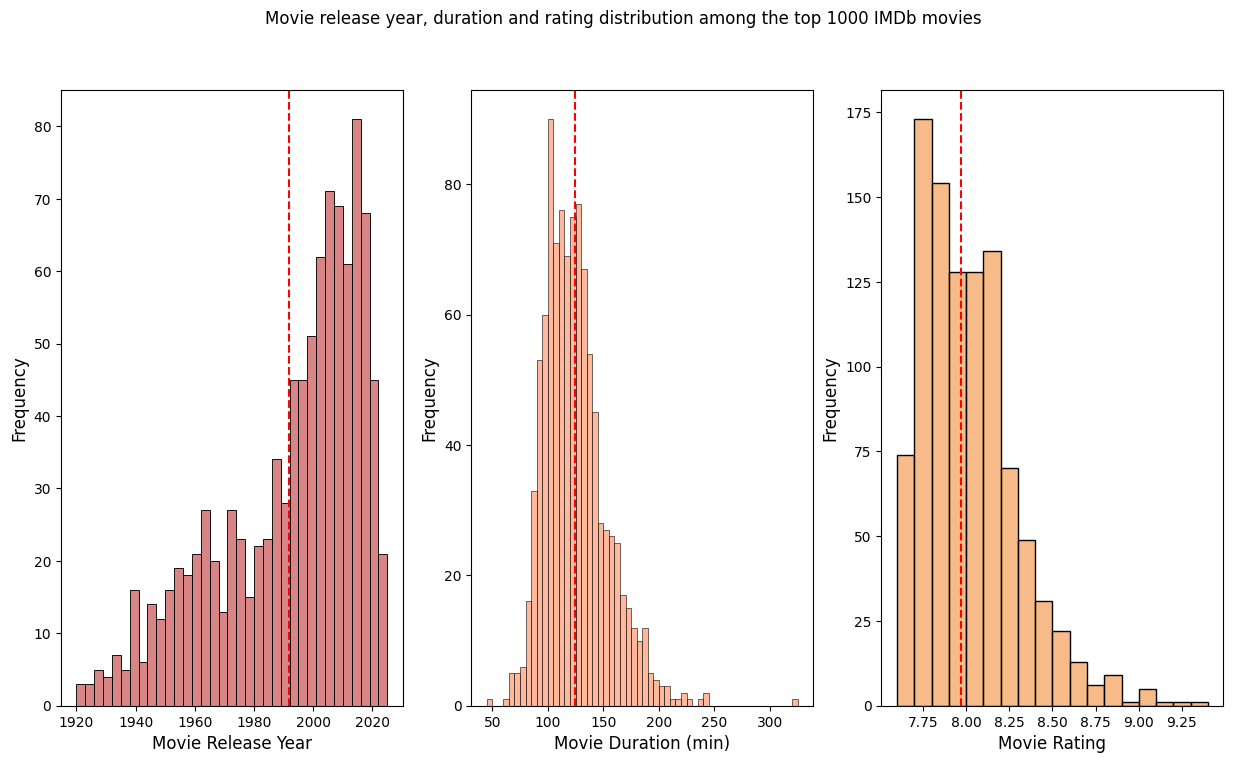

The average movie release year within the movies in IMDb top 1000 is: 1991.652.
The average duration within the movies in IMDb top 1000 is: 124.103.
The average rating among the top 1000 IMDb movies: 7.969099999999999.


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,8))

# plotting the Movie Release Year histogram
plot1 = sns.histplot(final_df['Year'], binwidth=3, ax=axes[0], color = "indianred")
plot1.set_xlabel('Movie Release Year', fontdict={'size': 12})
plot1.set_ylabel('Frequency', fontdict={'size': 12})
plot1.axvline(x=final_df['Year'].mean(),color='red', linestyle = '--')

# plotting the movie duration histogram 
plot2 = sns.histplot(final_df['Run Time(min)'], binwidth=5, ax=axes[1], color = "lightsalmon")
plot2.axvline(x=final_df['Run Time(min)'].mean(),color='red', linestyle = '--')
plot2.set_xlabel('Movie Duration (min)', fontdict={'size': 12})
plot2.set_ylabel('Frequency', fontdict={'size': 12})

# plotting the rating distribution
plot3 = sns.histplot(final_df['Rating'], binwidth=0.1, ax=axes[2], color = "sandybrown")
plot3.axvline(x=final_df['Rating'].mean(),color='red', linestyle = '--')
plot3.set_xlabel('Movie Rating', fontdict={'size': 12})
plot3.set_ylabel('Frequency', fontdict={'size': 12})

fig.suptitle("Movie release year, duration and rating distribution among the top 1000 IMDb movies", fontsize = 'large')
plt.show()

print(f"The average movie release year within the movies in IMDb top 1000 is: {final_df['Year'].mean()}.\nThe average duration within the movies in IMDb top 1000 is: {final_df['Run Time(min)'].mean()}.")
print(f"The average rating among the top 1000 IMDb movies: {final_df['Rating'].mean()}.")

From the above histograms and mean calculations, we can see that the most movies within the top-1000 were released in ~2018, while the average movie in the top is released ~1990-2000. We can see that the movies are scewed towards 2020ies. <br><br> As to movie duration, we can see that most common movie length is ~ 90 minutes, while on average movies within the top are around 125 minutes. We can see an outlier at around 325 minutes. <br><br> The average movie rating within the top is ~7.95, while most common rating is 7.75. The histogram is scewed towards 7.5, which suggests that the majority of movies within the top are rated below 8.5. 

#### Movie release year, duration and rating bar plots

Since we saw an outlier in the histograms above, I decided to plot bar plots to take a closer look at these data points. I plotted a bar plot for every histogram from above.

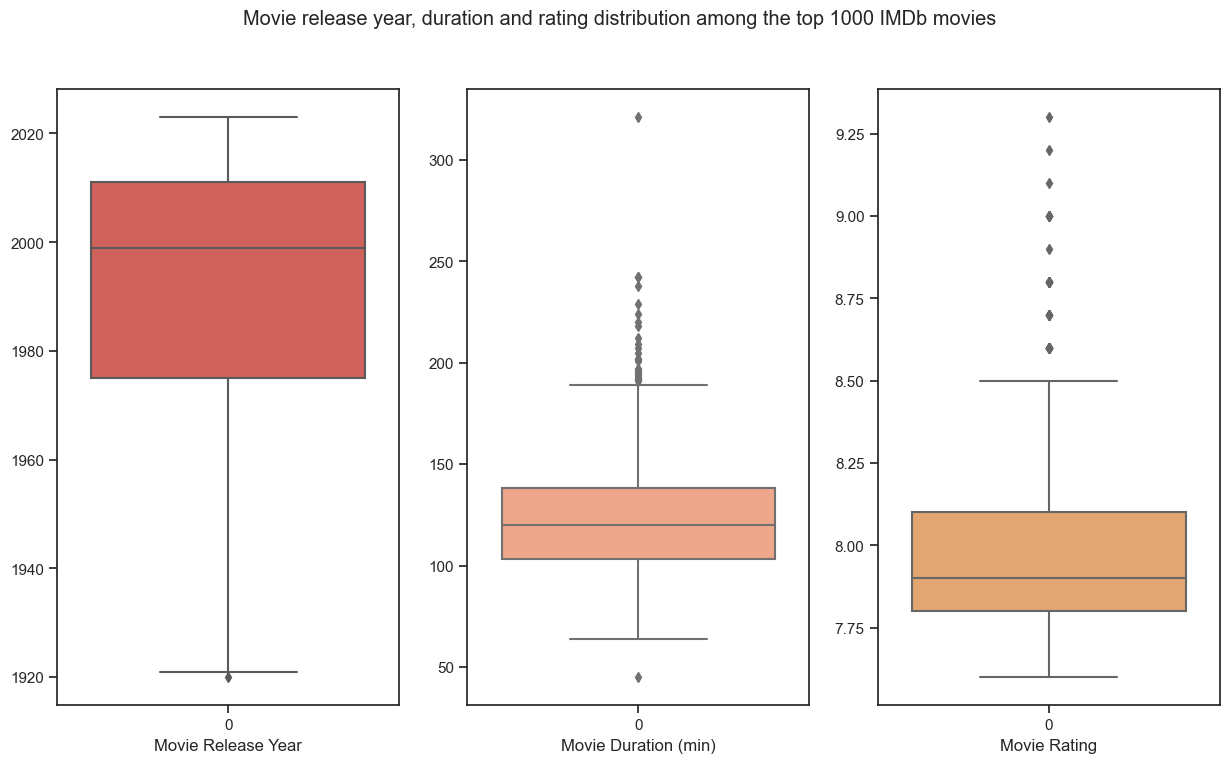

In [487]:
fig, axes = plt.subplots(1, 3, figsize=(15,8))

# plotting the Movie Release Year histogram
plot1 = sns.boxplot(final_df['Year'], ax=axes[0])
plot1.set_xlabel('Movie Release Year', fontdict={'size': 12})

# plotting the movie duration histogram 
plot2 = sns.boxplot(final_df['Run Time(min)'], ax=axes[1], color = "lightsalmon")
plot2.set_xlabel('Movie Duration (min)', fontdict={'size': 12})

# plotting the rating distribution
plot3 = sns.boxplot(final_df['Rating'], ax=axes[2], color = "sandybrown")
plot3.set_xlabel('Movie Rating', fontdict={'size': 12})

fig.suptitle("Movie release year, duration and rating distribution among the top 1000 IMDb movies", fontsize = 'large')
plt.show()

As we can see, there are multiple outliers present. If the outliers are simple errors from web scraping or data cleaning, it is better to handle them (eg. delete, etc) so that we can get more meaningful and true insights without the noise. However, if the outliers are real data points, deleting them or otherwise handling them would be misrepresentative of the data. <br><br> I was especially curious about the outliers in the movie duration and decided to check whether they are just noise or real data points. All the outliers within movie duration do exist in the original dataset, which one can check by going to the IMDb top-1000 website and sorting by decreasing duration. For example, the longest film on the list is Gangs of Wasseypur, which lasts 321 minutes. Hence, since the outliers represent actual data points, we do not have to handle them since this would misrepresent the data.

#### Scatter plots

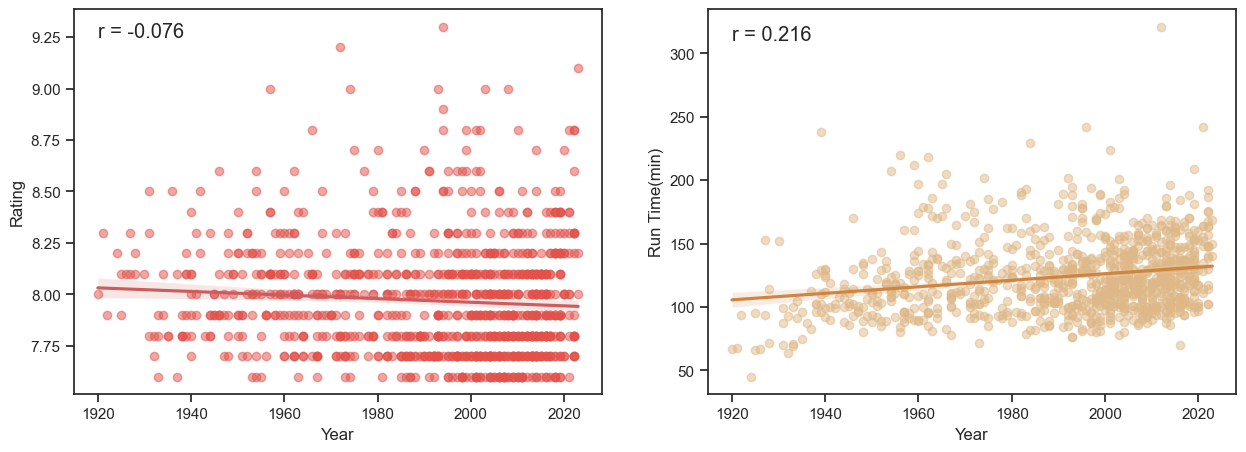

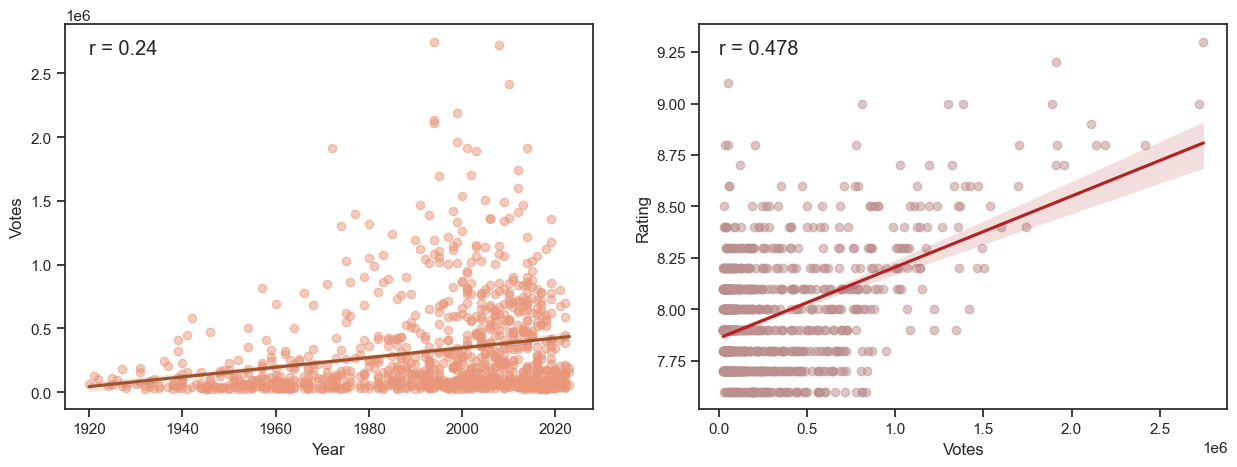

In [668]:
# plotting Year vs Rating and Year vs Run Time scatterplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.regplot(x = "Year", y = "Rating", data = final_df,
            scatter_kws = {"alpha": 0.5}, 
            line_kws = {"color": "indianred"}, ax = axes[0])
axes[0].text(1920, 9.25, f"r = {c1}", size = "large")
sns.regplot(data=final_df, x="Year", y="Run Time(min)", ax = axes[1], 
            scatter_kws = {"color": "burlywood", "alpha": 0.5}, 
           line_kws = {"color": "peru"}) 
axes[1].text(1920, 310, f"r = {c2}", size = "large")
plt.show()

# plotting Year vs Votes and Votes vs Rating scatterplots
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.regplot(data=final_df, x="Year", y="Votes", ax = axes[0], 
            scatter_kws = {"color": "darksalmon", "alpha": 0.5}, 
           line_kws = {"color": "sienna"})
axes[0].text(1920, 2650000, f"r = {c3}", size = "large")
sns.regplot(data=final_df, x="Votes", y="Rating", ax = axes[1], 
            scatter_kws = {"color": "rosybrown", "alpha": 0.5}, 
           line_kws = {"color": "firebrick"})
axes[1].text(0.0, 9.24, f"r = {c4}", size = "large")
plt.show()

From the scatterplots above we can see the correlation between different movie characteristics. We can see a negative correlation between year and rating, where the average rating of a movie within the top decreases the newer the movie is. However, this correlation can be explained by the "Year" histogram from above. There is simply more newer movies in the top then older movies. Hence, in order to get a clearer sense of the correlation, we could calculate a weighted correlation, which would reflect year vs rating relationship more accurately. <br> <br> On the Year vs Run Time scatterplot, we see a slight positive correlation, meaning that, on average, newer movies are longer than older ones within the top. <br><br> On the third scatterplot we see a slight positive correlation between Year and number of votes, suggesting that the newer the movie is the smovie votes it will gather, which makes sense intuitively. <br><br> On the last graph we see a slight positive correlation between the number of votes and the rating, which shows that the more votes the movie has gathered the better rated it is. 

In [670]:
import scipy.stats
corr = scipy.stats.pearsonr(final_df["Year"], final_df["Rating"]) # significant
corr2 = scipy.stats.pearsonr(final_df["Year"], final_df["Run Time(min)"]) # significant
corr3 = scipy.stats.pearsonr(final_df["Year"], final_df["Votes"]) # significant
corr4 = scipy.stats.pearsonr(final_df["Votes"], final_df["Rating"]) # significant
c1, c2, c3, c4 = round(corr[0], 3), round(corr2[0], 3), round(corr3[0], 3), round(corr4[0], 3)

In the above cell I calculated the significance of each correlation, and each of the p-values was smaller than 0.05, implying that the correlation between the characteristics is significant.

#### Genres Distribution

In the below code I am creating a separate dataframe to break down the combination of genres we see in the dataframe above into invidual genres. I am going through each movie and its genres in the corresponding cell of the dataframe and checking which genres the cell includes. 

In [581]:
genres_list1 = ['Drama', 'Crime', 'Animation', 'Action', 'Adventure', 'Biography', 'History', 'Sci-Fi', 'Mystery', 'Comedy', 'Romance', 'Thriller', 'Horror', 'War']

In [579]:
top_1000_genres = pd.DataFrame(np.nan, index=np.arange(0, 999), columns=genres_list1)

In [3]:
for g in genres_list1:
    for i in range(0, 999):
        vals = final_df.iloc[[i],[3]].values
        val_string = [v for val in vals for v in val]
        if str(g) in str(val_string):
            top_1000_genres.iloc[[i],[genres_list1.index(g)]] = "Yes"

In [587]:
# converting to csv for storage
top_1000_genres.to_csv('IMDb_top1000_genres_table', sep=',', index=False, encoding='utf-8')

In [588]:
# the resulting dataframe
top_1000_genres.head()

,Drama,Crime,Animation,Action,Adventure,Biography,History,Sci-Fi,Mystery,Comedy,Romance,Thriller,Horror,War
0,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yes,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yes,NaN,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the below cell I am creating a separate dataframe storing only genres and their occurrence within the top-1000 movies. Then I am sorting the occurrences and creating a barplot to see the distribution of genres within the top-1000 movies more clearly.

In [15]:
genres = {"Drama": top_1000_genres['Drama'].value_counts()[0], 
         "Crime": top_1000_genres['Crime'].value_counts()[0],
         "Animation": top_1000_genres['Animation'].value_counts()[0], 
         "Action": top_1000_genres['Action'].value_counts()[0], 
         "Adventure": top_1000_genres['Adventure'].value_counts()[0], 
         "Biography": top_1000_genres['Biography'].value_counts()[0], 
         "History": top_1000_genres['History'].value_counts()[0], 
         "Sci-Fi": top_1000_genres['Sci-Fi'].value_counts()[0], 
         "Mystery": top_1000_genres['Mystery'].value_counts()[0], 
         "Comedy": top_1000_genres['Comedy'].value_counts()[0], 
         "Romance": top_1000_genres['Romance'].value_counts()[0], 
         "Thriller": top_1000_genres['Thriller'].value_counts()[0], 
         "Horror": top_1000_genres['Horror'].value_counts()[0], 
         "War": top_1000_genres['War'].value_counts()[0]}
genres = pd.DataFrame(genres.items())

In [18]:
genres.columns = ["Genre", "Occurrence"]

In [19]:
genres = genres.sort_values(by = "Occurrence", ascending = False)

In [21]:
genres.to_csv('IMDb_top1000_genres_table_counts', sep=',', index=False, encoding='utf-8')

[Text(0.5, 1.0, 'Occurrence of movies containing a certain genre')]

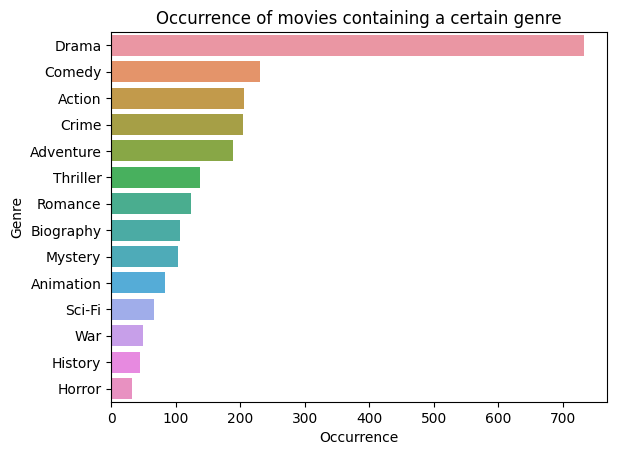

In [24]:
sns.barplot(x=genres.Occurrence, y=genres.Genre, orient='h').set(title = "Occurrence of movies containing a certain genre")

The box plot above shows that Drama is most common genre within the top, it has occured in over 700 of 1000 movies. Comedy, action and crime have occurred in around 200 movies from the top. Ones of the least common genres are horror, history and war, they occurr in only ~ 50 movies each.

## Metadata-based recommendation system

In the code below I am combining a movie's description, actors, directors and genres into one string, which is then compared to similar strings of other movies using consine similarity. I am using CountVectorizer to convert the strings into numbers for cosine similarity function to be able to compute similarity. I am then using the similarity to rank movies from most similar to a given movie to least similar. Top ten movies are then returned as recommendations!

In [80]:
def soupifying(x):
    """
    Combines specific columns of a DataFrame into a single string.

    Args:
        x (pandas.Series): A row of a DataFrame containing columns 'Descriptions', 'Stars', 'Directors', and 'Genre'.

    Returns:
        str: A combined string of the values from 'Descriptions', 'Stars', 'Directors', and 'Genre'.

    """
    return x['Descriptions'] + ' ' + x['Stars'] + ' ' + x['Directors'] + ' ' + x['Genre']

In [81]:
# axis = 1 bc we want the function to be applied to every row in the df
final_df['Soup'] = final_df.apply(soupifying, axis=1)

In [11]:
final_df.head()

,Title,Year,Run Time(min),Genre,Rating,Votes,Directors,Stars,Descriptions,Soup
0,The Shawshank Redemption,1994,142,Drama,9.3,2749930.0,FrankDarabont,TimRobbins MorganFreeman BobGunton WilliamSadler,"Over the course of several years, two convicts...","Over the course of several years, two convicts..."
1,The Godfather,1972,175,"Crime, Drama",9.2,1912737.0,FrancisFordCoppola,MarlonBrando AlPacino JamesCaan DianeKeaton,"Don Vito Corleone, head of a mafia family, dec...","Don Vito Corleone, head of a mafia family, dec..."
2,Spider-Man: Across the Spider-Verse,2023,140,"Animation, Action, Adventure",9.0,95163.0,sJoaquimDosSantos KempPowers JustinKThompson,ShameikMoore HaileeSteinfeld BrianTyreeHenry L...,"Miles Morales catapults across the Multiverse,...","Miles Morales catapults across the Multiverse,..."
3,The Dark Knight,2008,152,"Action, Crime, Drama",9.0,2722695.0,ChristopherNolan,ChristianBale HeathLedger AaronEckhart Michael...,When the menace known as the Joker wreaks havo...,When the menace known as the Joker wreaks havo...
4,Schindler's List,1993,195,"Biography, Drama, History",9.0,1386866.0,StevenSpielberg,LiamNeeson RalphFiennes BenKingsley CarolineGo...,"In German-occupied Poland during World War II,...","In German-occupied Poland during World War II,..."


In [13]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words = "english")
cv_matrix = cv.fit_transform(final_df['Soup'])

from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(cv_matrix, cv_matrix) # calculates the similarity between every vector

(1000, 1000)


In [173]:
# converting the cosine similarities into a dataframe
# the dataframe has movies as its axes and the cells corresponding to two given
# movies has their cosine similarity score
sim_df = pd.DataFrame(cos_sim, columns = final_df["Title"].tolist(), index = final_df["Title"].tolist())

In [174]:
sim_df.head(10)

,The Shawshank Redemption,The Godfather,Spider-Man: Across the Spider-Verse,The Dark Knight,Schindler's List,The Godfather Part II,The Lord of the Rings: The Return of the King,12 Angry Men,Pulp Fiction,Inception,...,Barton Fink,25th Hour,United 93,The Taking of Pelham One Two Three,Philomena,A Very Long Engagement,Control,Shine,The Invisible Man,Cell 211
The Shawshank Redemption,1.000000,0.046676,0.000000,0.048507,0.049507,0.046676,0.050572,0.048507,0.108465,0.000000,...,0.052926,0.048507,0.045835,0.000000,0.048507,0.054233,0.049507,0.103418,0.000000,0.046676
The Godfather,0.046676,1.000000,0.000000,0.076980,0.039284,0.407407,0.040129,0.076980,0.129099,0.000000,...,0.041996,0.038490,0.036370,0.037037,0.076980,0.043033,0.039284,0.041030,0.000000,0.074074
Spider-Man: Across the Spider-Verse,0.000000,0.000000,1.000000,0.070711,0.000000,0.034021,0.073721,0.035355,0.000000,0.098480,...,0.038576,0.035355,0.033408,0.068041,0.000000,0.000000,0.000000,0.000000,0.000000,0.034021
The Dark Knight,0.048507,0.076980,0.070711,1.000000,0.040825,0.115470,0.083406,0.080000,0.089443,0.074278,...,0.043644,0.040000,0.075593,0.076980,0.040000,0.044721,0.040825,0.042640,0.000000,0.115470
Schindler's List,0.049507,0.039284,0.000000,0.040825,1.000000,0.039284,0.085126,0.040825,0.045644,0.000000,...,0.044544,0.040825,0.077152,0.000000,0.122474,0.136931,0.083333,0.087039,0.000000,0.039284
The Godfather Part II,0.046676,0.407407,0.034021,0.115470,0.039284,1.000000,0.040129,0.230940,0.129099,0.000000,...,0.125988,0.153960,0.036370,0.222222,0.076980,0.043033,0.039284,0.041030,0.000000,0.111111
The Lord of the Rings: The Return of the King,0.050572,0.040129,0.073721,0.083406,0.085126,0.040129,1.000000,0.041703,0.046625,0.116160,...,0.045502,0.041703,0.078811,0.080257,0.083406,0.093250,0.042563,0.044455,0.000000,0.120386
12 Angry Men,0.048507,0.076980,0.035355,0.080000,0.040825,0.230940,0.041703,1.000000,0.089443,0.000000,...,0.130931,0.120000,0.037796,0.230940,0.040000,0.044721,0.040825,0.042640,0.000000,0.076980
Pulp Fiction,0.108465,0.129099,0.000000,0.089443,0.045644,0.129099,0.046625,0.089443,1.000000,0.000000,...,0.048795,0.044721,0.042258,0.043033,0.044721,0.050000,0.045644,0.047673,0.000000,0.086066
Inception,0.000000,0.000000,0.098480,0.074278,0.000000,0.000000,0.116160,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.035093,0.035737,0.000000,0.000000,0.000000,0.000000,0.095893,0.035737


In [203]:
def recommender(similarity, dataframe, movie_title, n):
    """
    Recommends movies based on cosine similarity scores.

    Args:
        similarity (numpy.ndarray): A 2D array containing similarity scores between movies.
        dataframe (pandas.DataFrame): The original DataFrame containing movie information.
        movie_title (str): The title of the movie for which recommendations are desired.
        n (int): The number of movies to recommend.

    Returns:
        str: A formatted string listing the recommended movies based on similarity to the input movie.

    """
    sim_df = pd.DataFrame(similarity, columns = dataframe["Title"].tolist(), index = dataframe["Title"].tolist())
    half_sim_df = pd.DataFrame(np.tril(sim_df),  columns = dataframe["Title"].tolist(), index = dataframe["Title"].tolist())
    recommended_df = half_sim_df.nlargest(n+1, [movie_title])
    recommended_titles = recommended_df.index.values[1:n+1]
    output = "\n".join(recommended_titles)
    return f'The {n} movies recommended based on {movie_title} are:\n\n{output}'

In [206]:
print(recommender(cos_sim, final_df,"Inception", 10))

The 10 movies recommended based on Inception are:

X-Men: Days of Future Past
Interstellar
Serenity
Edge of Tomorrow
The Prestige
The Revenant
The Avengers
Avengers: Infinity War
The Martian
Iron Man


Here, I tested the function, and it seems like it works pretty well. However, there are certainly quite a few limitattions to this very simple recommendation system. Firstly, the suggestions it makes are not personal, so if two different people inputted "Inception", they would get exactly same results. Hence, the system is not personalised, which is important since different people have their own biases, likes and dislikes. Secondly, the system is only limited to the movies in our dataset, the top 1000 IMDb movies. So, if we wanted to get recommendations based on a movie outside of the dataset, the system would not be able to provide any. Thirdly, since the system is not personal, it does not know which movies you have already watched and which have not.

We would get more accurate results using a user-user, item-item or matrix based recommendation system, since they would provide the personalisation aspect that this system is lacking.